# Prediction of sea ice extent over the Arctic

### By [Fruzsina Agocs](https://www.kicc.cam.ac.uk/directory/fa325@ast.cam.ac.uk), based on [this notebook](https://github.com/scott-hosking/notebooks/blob/master/sea_ice_regression.ipynb) by Dr. Scott Hosking.

In this notebook you'll find code to:

- retrieve gridded time series of: the NAO index, the AO index, the NINO index, CO2 concentration, and an estimate of total sea ice area over an area (the Barents and Kara seas);
- fit a Gaussian process over this as function of time.

Reading:

- [Gaussian processes by Rasmussen](http://www.gaussianprocess.org/gpml/)
- [The compound kernel used in this example](https://scikit-learn.org/stable/modules/gaussian_process.html#gpr-on-mauna-loa-co2-data)
- [Gaussian processes website](http://www.gaussianprocess.org/)
- [GPFlow documentation & examples](https://gpflow.readthedocs.io/en/master/?badge=master)

## 1. Retrieve and visualise data 

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xarray as xr
import tensorflow as tf
import gpflow 
from gpflow.kernels import RBF, Periodic, RationalQuadratic, White

import warnings
warnings.simplefilter('ignore')

### Download datasets

No need, this has already been done for you! They are in `sea_ice_data/`.

In [3]:
def reshape_col_month(df, col_name):
    """ Processing data from dataframe - change from one column for year to two separate columns for year and month """
    new = pd.DataFrame(columns=['Year', 'Month', col_name])
    yr_arr, mon_arr = [], []
    for yr in df['Year'].values:
        yr_arr  = np.append( yr_arr, np.repeat(yr,12) )
        mon_arr = np.append( mon_arr, np.arange(1,13) )
    new['Year']   = yr_arr.astype(int)
    new['Month']  = mon_arr.astype(int)
    new[col_name] = np.array(df.drop(['Year'], axis=1)).flatten()
    return new

In [264]:
def plot(x, y, labels):
    """ Convenience function for plotting climate variables. """
    plt.figure()
    plt.plot(x,y)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.title(labels[1])
    plt.show()

Load weather data: 

In [223]:
url = 'sea_ice_data/norm.nao.monthly.b5001.current.ascii.table'
nao = pd.read_csv(url, delim_whitespace=True, header=None)
nao.rename(columns = {0: 'Year'}, inplace=True)
nao = reshape_col_month(nao, 'NAO')
nao['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in nao.iterrows() ]
nao['time'] = pd.DatetimeIndex(dt)
nao = nao.drop(columns=['Day'])

url = 'sea_ice_data/nino34.long.anom.data'
nino = pd.read_csv(url, skiprows=1, skipfooter=7, delim_whitespace=True, header=None)
nino.rename(columns = {0: 'Year'}, inplace=True)
nino = reshape_col_month(nino, 'NINO')
nino['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in nino.iterrows() ]
nino['time'] = pd.DatetimeIndex(dt)
nino = nino.drop(columns=['Day'])

url = 'sea_ice_data/ao.data'
ao = pd.read_csv(url, skiprows=1, skipfooter=3, delim_whitespace=True, header=None)
ao.rename(columns = {0: 'Year'}, inplace=True)
ao = reshape_col_month(ao, 'AO')
ao['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in ao.iterrows() ]
ao['time'] = pd.DatetimeIndex(dt)

url = 'sea_ice_data/co2_mm_mlo.txt'
co2 = pd.read_csv(url, skiprows=72, delim_whitespace=True, usecols=[0,1,3], names=['Year','Month','CO2'])
co2['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in co2.iterrows() ]
co2['time'] = pd.DatetimeIndex(dt)

# Merge time series
df = pd.merge(nino,nao)
df = pd.merge(df,ao)
df = pd.merge(df,co2)
df = df.drop(columns=['Day'], axis=0)
df = df.to_xarray()

# Load sea ice data
ds = np.loadtxt('sea_ice_data/almers-sea-ice-timeseries.txt',\
                   delimiter=',',dtype=[('date',datetime.date), ('SIE',np.float64)])

The sea ice concentration is stored in as an `numpy.array`, the other time-series as an `xarray.DataSet` structure:

In [224]:
ds,ds.shape

(array([('1979-01-15', 47364256. ), ('1979-02-15', 51005130. ),
        ('1979-03-15', 50265816. ), ('1979-04-15', 51270076. ),
        ('1979-05-15', 48925108. ), ('1979-06-15', 43084730. ),
        ('1979-07-15', 31173720. ), ('1979-08-15', 18767550. ),
        ('1979-09-15', 10540187. ), ('1979-10-15', 24986690. ),
        ('1979-11-15', 34601264. ), ('1979-12-15', 42321264. ),
        ('1980-01-15', 43759700. ), ('1980-02-15', 46727744. ),
        ('1980-03-15', 45328500. ), ('1980-04-15', 46678150. ),
        ('1980-05-15', 42673012. ), ('1980-06-15', 39604144. ),
        ('1980-07-15', 32173972. ), ('1980-08-15', 23244418. ),
        ('1980-09-15', 20425898. ), ('1980-10-15', 26293846. ),
        ('1980-11-15', 38623292. ), ('1980-12-15', 45487524. ),
        ('1981-01-15', 45105550. ), ('1981-02-15', 43538400. ),
        ('1981-03-15', 47986772. ), ('1981-04-15', 48515040. ),
        ('1981-05-15', 48437300. ), ('1981-06-15', 41193172. ),
        ('1981-07-15', 32862172. ), ('19

In [225]:
df

<xarray.Dataset>
Dimensions:  (index: 735)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 7 8 ... 727 728 729 730 731 732 733 734
Data variables:
    Year     (index) int64 1958 1958 1958 1958 1958 ... 2019 2019 2019 2019 2019
    Month    (index) int64 3 4 5 6 7 8 9 10 11 12 1 ... 7 8 9 10 11 12 1 2 3 4 5
    NINO     (index) float64 0.99 0.31 0.32 0.3 0.04 ... 0.62 0.81 0.67 -99.99
    time     (index) datetime64[ns] 1958-03-15 1958-04-15 ... 2019-05-15
    NAO      (index) float64 -1.96 0.37 -0.24 -1.38 ... 0.29 1.23 0.47 -2.62
    AO       (index) float64 -2.522 -0.36 -0.336 -1.149 ... 2.116 -0.255 -1.231
    CO2      (index) float64 315.7 317.4 317.5 -99.99 ... 412.0 413.3 414.7

Take slice over the satellite period (1979 onwards) for the weather indices:

In [226]:
df = df.where(df.Year>1978,drop=True)
df = df.where(df.Year<2014,drop=True)
df

<xarray.Dataset>
Dimensions:  (index: 420)
Coordinates:
  * index    (index) int64 250 251 252 253 254 255 ... 664 665 666 667 668 669
Data variables:
    Year     (index) float64 1.979e+03 1.979e+03 ... 2.013e+03 2.013e+03
    Month    (index) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 8.0 9.0 10.0 11.0 12.0
    NINO     (index) float64 0.05 0.09 0.13 0.17 ... -0.09 -0.24 -0.02 -0.09
    time     (index) datetime64[ns] 1979-01-15 1979-02-15 ... 2013-12-15
    NAO      (index) float64 -1.38 -0.67 0.78 -1.71 ... 0.24 -1.28 0.9 0.95
    AO       (index) float64 -2.233 -0.697 -0.814 -1.157 ... 0.263 2.029 1.475
    CO2      (index) float64 336.1 336.7 338.3 338.9 ... 393.4 393.7 395.2 396.8

Remove missing data point (missing CO2 data point in 1984)

In [227]:
missing_index = np.where(ds['date']=='1984-04-15')
dates = np.delete(ds['date'],np.where(ds['date']=='1984-04-15'))
df = df.where(df.index!=250+missing_index[0],drop=True)
df

<xarray.Dataset>
Dimensions:  (index: 419)
Coordinates:
  * index    (index) int64 250 251 252 253 254 255 ... 664 665 666 667 668 669
Data variables:
    Year     (index) float64 1.979e+03 1.979e+03 ... 2.013e+03 2.013e+03
    Month    (index) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 8.0 9.0 10.0 11.0 12.0
    NINO     (index) float64 0.05 0.09 0.13 0.17 ... -0.09 -0.24 -0.02 -0.09
    time     (index) datetime64[ns] 1979-01-15 1979-02-15 ... 2013-12-15
    NAO      (index) float64 -1.38 -0.67 0.78 -1.71 ... 0.24 -1.28 0.9 0.95
    AO       (index) float64 -2.233 -0.697 -0.814 -1.157 ... 0.263 2.029 1.475
    CO2      (index) float64 336.1 336.7 338.3 338.9 ... 393.4 393.7 395.2 396.8

Generate data to feed in to `GPFlow`:

In [241]:
X = df[['Month','NAO','NINO','AO','CO2']]
Y = np.delete(ds['SIE'],missing_index)
yrs = df['Year'].values

In [242]:
X

<xarray.Dataset>
Dimensions:  (index: 419)
Coordinates:
  * index    (index) int64 250 251 252 253 254 255 ... 664 665 666 667 668 669
Data variables:
    Month    (index) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 8.0 9.0 10.0 11.0 12.0
    NAO      (index) float64 -1.38 -0.67 0.78 -1.71 ... 0.24 -1.28 0.9 0.95
    NINO     (index) float64 0.05 0.09 0.13 0.17 ... -0.09 -0.24 -0.02 -0.09
    AO       (index) float64 -2.233 -0.697 -0.814 -1.157 ... 0.263 2.029 1.475
    CO2      (index) float64 336.1 336.7 338.3 338.9 ... 393.4 393.7 395.2 396.8

Convert x-axis values to `datetime.date` objects for ease of plotting:

In [261]:
dates = np.array([datetime.datetime.strptime(d, "%Y-%m-%d").date() for d in dates])

Now look at all time series data.

### NAO
- Low pressure system over Iceland and high pressure system over the Azores control the direction and strength of westerly winds into Europe,
- the NAO index encodes the pressure difference between these two points,
- large +ve index brings cool summers and mild, wet winters in Central Europe, -ve index is associated with cold, dry winters in Northern Europe and storms in Southern Europe,

### AO
- Close relative of the NAO
- ringlike pressure anomalies centered on the poles
- believed to be causally related to global weather patterns

### NINO
- El Nino-Southern oscillation index,
- drives winds and sea surface temperatures across the tropical Pacific

### CO2 concentration
- Atmospheric concentration of CO2 at the Mauna Loa observatory, Hawaii    

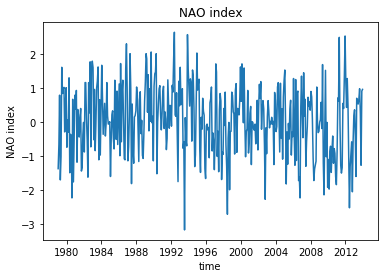

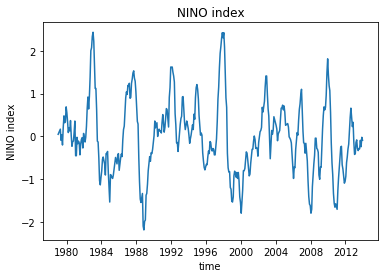

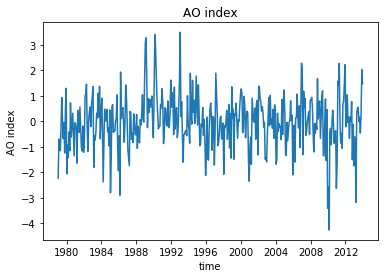

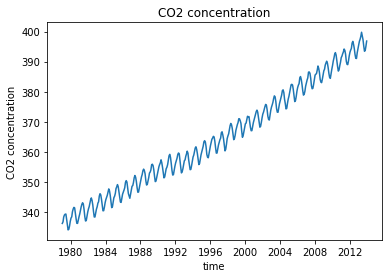

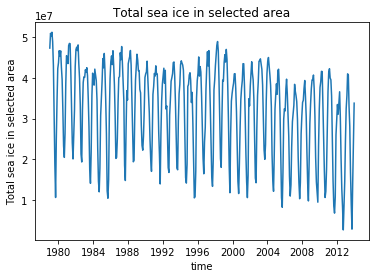

In [266]:
%matplotlib inline
plot(dates,X['NAO'].values, ['time','NAO index'])
plot(dates,X['NINO'].values, ['time', 'NINO index'])
plot(dates,X['AO'].values, ['time', 'AO index'])
plot(dates,X['CO2'].values, ['time', 'CO2 concentration'])
plot(dates,Y, ['time', 'Total sea ice in selected area'])

## Predicition of sea ice extent in an area (over Barents-Kara seas)

### 1. Naive time series

In this first attempt, we shall fit a GP to the sea ice extent as a function of time only. We'll be using a kernel of the form discussed in Rasmussen (2006), Ch 5.4.3 "Mauna Loa CO2".

The training/testing set split is at 2010.

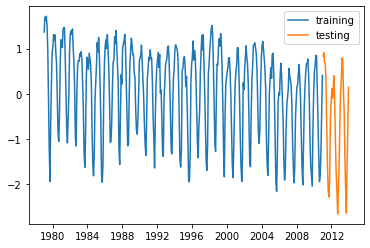

In [267]:
# Split data into training and testing datasets
train_ind, test_ind = np.where(yrs <= 2010)[0], np.where(yrs > 2010)[0]
Y_scaled = preprocessing.scale(Y)
X_train_dates, X_test_dates, Y_train, Y_test = dates[train_ind], dates[test_ind],\
                                    Y_scaled[train_ind], Y_scaled[test_ind]

plt.figure()
plt.plot(X_train_dates, Y_train,label='training')
plt.plot(X_test_dates, Y_test,label='testing')
plt.legend()
plt.show()

Enter the 4-component kernel:

In [5]:
# Design kernel

k1 = RBF(lengthscales=32, variance=0.5**2)
k2 = Periodic(RBF(lengthscales=100., variance=1), period=1)
k3 = RationalQuadratic(alpha=100, lengthscales=10., variance=0.5**2)
k4 = RBF(lengthscales=0.2, variance=0.01**2) + White(variance=1e-5)
kernel = k1+k2+k3+k4

In [270]:
kernel

,class,prior,transform,trainable,shape,fixed_shape,value
Sum/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,32.0
Sum/kernels/0/variance,Parameter,None,+ve,True,(),True,0.25
Sum/kernels/1/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,5.0
Sum/kernels/1/kernels/0/variance,Parameter,None,+ve,True,(),True,1.0
Sum/kernels/1/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,1.2
Sum/kernels/1/kernels/1/period,Parameter,None,+ve,True,(),True,1.0
Sum/kernels/1/kernels/1/variance,Parameter,None,+ve,True,(),True,1.0
Sum/kernels/2/alpha,Parameter,None,+ve,True,(),True,100.0
Sum/kernels/2/lengthscales,Parameter,None,+ve,True,(),True,10.0
Sum/kernels/2/variance,Parameter,None,+ve,True,(),True,0.25


The following is just for convenience: We replace values on the x-axis by time measured in years, and reshape the data containers for processing by `GPflow`.

In [279]:
X_train = np.array([(X_train_date - X_train_dates[0]).days/365. for X_train_date in X_train_dates])
X_test = np.array([(X_test_date - X_train_dates[0]).days/365. for X_test_date in X_test_dates])
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
Y_train = Y_train.reshape(-1,1)

Train the GP - i.e. optimise kernel hyperparameters:

In [280]:
model = gpflow.models.GPR(X_train.astype('float64'),
                         Y_train.astype('float64'),
                         kernel)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables, track_loss_history = True)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -2.616573
  Number of iterations: 35
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -2.616573
  Number of iterations: 35
  Number of functions evaluations: 54


Prepare data to plot predictions and ask `GPflow` to predict observations based on the trained model:

In [281]:
X_all_dates = dates.reshape(-1,1)
X_all = np.array([(X_all_date[0] - X_all_dates[0][0]).days/365. for X_all_date in X_all_dates])
X_all = X_all.reshape(-1,1)
Y_pred_mean, Y_pred_var = model.predict_y(X_all)

Plot the predicted observations (mean + standard deviation):

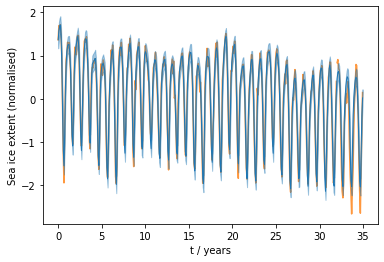

In [329]:
plt.figure()
plt.plot(X_all, Y_pred_mean, lw=1,color='C0',zorder=9)
plt.fill_between(X_all.flatten(), np.array(Y_pred_mean - np.sqrt(np.diag(Y_pred_var))).flatten(),
                 np.array(Y_pred_mean + np.sqrt(np.diag(Y_pred_var))).flatten(),
                 alpha=0.4,color='C0',zorder=9)
plt.plot(X_train, Y_train,color='C1',alpha=0.8)
plt.plot(X_test, Y_test,color='C1',alpha=0.8)
plt.xlabel('t / years')
plt.ylabel('Sea ice extent (normalised)')
plt.show()

## Your work here :)